# inter-run comparisons of N contained in phytoplankton
    - S3
    - Sentry Shoal
    - Central Node
    - JDF

In [1]:
import pandas as pd
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
import gsw
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

In [2]:
plist=['Sentry Shoal','S3','Central node','Central SJDF']

In [56]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]
#stm=np.shape(tmask)

In [11]:
#saveloc='/data/eolson/MEOPAR/SS36runs/calcFiles/comparePhytoN/'
baseloc='/data/eolson/MEOPAR/SS36runs/CedarRuns/'
dirname1='spring16spun_Z6'
dirname2='hindcast2016'
dirnames=(dirname1,)
#dirnames=('spring2015_NewSink','spring2015_slowPP','spring2015_KhT','spring2015_diatHS')
varNameDict={'Sentry Shoal':'SentryShoal', 'S3':'S3', 'Central node':'CentralNode', 'Central SJDF':'CentralSJDF'}
with open('/ocean/eolson/MEOPAR/analysis-elise/notebooks/bioTuning/spathsMaster.txt') as f:
    spaths = dict(x.strip().split() for x in f)
#spaths={'spring2015_NewSink':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_NewSink/',
#    'spring2015_KhT':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_KhT/',
#    'spring2015_uzoo':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzoo/',
#    'spring2015_uzoo2':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzoo2/',
#    'spring2015_slowPP':'/data/eolson/results/MEOPAR/SS36runs/OrcinusRuns/spring2015_slowPP/',
#    'spring2015_lowMuNano':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_lowMuNano/',
#    'spring2015_SMELTBFastSink':'/data/eolson/results/MEOPAR/SS36runs/OrcinusRuns/spring2015_SMELTBFastSink/',
#    'spring2015_uzPref':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzPref/',
#    'spring2015_hiNH':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_hiNH/'}
ff=dict()
for idir in dirnames:
    ff[idir]=dict()
    for pl in plist:
        print(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
        ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
    #try:
    #    pl='Total'
    #    ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
    #except:
    #    pass

/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z6/ts_spring16spun_Z6_SentryShoal.nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z6/ts_spring16spun_Z6_S3.nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z6/ts_spring16spun_Z6_CentralNode.nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z6/ts_spring16spun_Z6_CentralSJDF.nc


In [12]:
spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc'

'/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z6/ts_spring16spun_Z6_CentralSJDF.nc'

In [13]:
spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc'

'/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z6/ts_spring16spun_Z6_CentralSJDF.nc'

In [14]:
times=dict()
for idir in dirnames:
    f=ff[idir]['S3']
    torig=dt.datetime.strptime(f.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
    print(torig)
    times[idir]=np.array([torig + dt.timedelta(seconds=ii) for ii in f.variables['time_centered'][:]])

1900-01-01 00:00:00


In [15]:
lcol={dirname1:{'votemper':'darkgreen','vosaline':'mediumblue'},
     dirname2:{'diatoms':'c','flagellates':'blueviolet','ciliates':'orange'}}
lsty={dirname1:'-',
      dirname2:'-'}

In [16]:
tmins=list()
tmaxs=list()
for idir in dirnames:
    tmins.append(times[idir][0])
    tmaxs.append(times[idir][-1])
xl=(np.min(np.array(tmins)),np.max(np.array(tmaxs)))

In [19]:
flist=['BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20150604T070624Z_20160307T160206Z-clean.csv',
      'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20160307T160215Z_20161019T064047Z-clean.csv',
      'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20161019T064056Z_20161115T220747Z-clean.csv']

In [20]:
dfs=list()
for ii in range(0,len(flist)):
    dfs.append(pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/'+flist[ii],
        skiprows=102,header=None,usecols=[0,1,2,3,4,5,6,7,8,9,10],
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC')))

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
df=pd.concat(dfs,ignore_index=True)

In [22]:
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]
df=df.assign(dts=dts)
df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')

In [24]:
llon=places.PLACES['S3']['lon lat'][0]-.01
ulon=places.PLACES['S3']['lon lat'][0]+.01
llat=places.PLACES['S3']['lon lat'][1]-.01
ulat=places.PLACES['S3']['lon lat'][1]+.01

In [25]:
iidfnd2=(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)

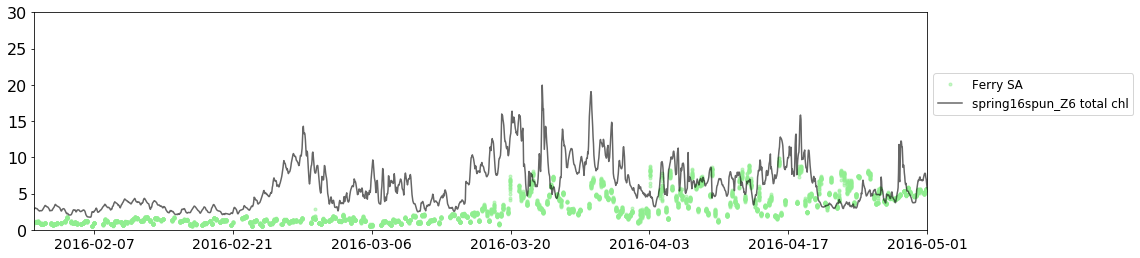

In [30]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(1,1,figsize=(16,1*(len(plist))))
ax=(ax,)
pl='S3'

ii=0
idir=dirname1
f=ff[idir][pl]
p01=ax[ii].plot(df.loc[iidfnd2,['dts']],[float(ik[0]) for ik in df.loc[iidfnd2,['Chlorophyll_ug']].values],'.',color='lightgreen',alpha=.5,
               label='Ferry SA')
p02=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
                          linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total chl')
ax[ii].set_xlim(dt.datetime(2016,2,1),dt.datetime(2016,5,1))
ax[ii].set_ylim(0,30)
ax[ii].legend(bbox_to_anchor=(1,.5),fontsize=12)
#p02=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
#                          linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')